Importing the needed libraries

In [5]:
#pip install --upgrade ipykernel

In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, phrases, ldamodel, CoherenceModel
import nltk
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook we will apply topic modelling and create three topics as given dataset consists of three authors and the excerpts from their horror stories. These authors are Edgar Allan Poe, Mary Shelley, and HP Lovecraft. Dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley.EAP work is around tales of mystery and the macabre. Mary Shelley work is around science fiction and  HP Lovecraft, best known as a writer of weird fiction.

In [7]:
# reading the data
authors_data_df = pd.read_csv("train/train.csv")
authors_data_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
authors_data_df.shape

(19579, 3)

In [9]:
# any null value
authors_data_df.isnull().sum()
# no null values

id        0
text      0
author    0
dtype: int64

In [10]:
#for the topic modelling we will focus only on the text data
authors_data_df = authors_data_df.drop(columns = ['id'], axis=1)
authors_data_df.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


# Inspecting data

In [11]:
authors_data_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

### The distribution of the excerpts script by author and we can view the number of excerpts are more for EAP then MWS and then HPL

#### Lets check the length of the excerpts

In [12]:
authors_data_df['text_length'] = authors_data_df['text'].map(lambda x: len(x))

In [13]:
print(authors_data_df.head())
print(authors_data_df.tail())

                                                text author  text_length
0  This process, however, afforded me no means of...    EAP          231
1  It never once occurred to me that the fumbling...    HPL           71
2  In his left hand was a gold snuff box, from wh...    EAP          200
3  How lovely is spring As we looked from Windsor...    MWS          206
4  Finding nothing else, not even gold, the Super...    HPL          174
                                                    text author  text_length
19574  I could have fancied, while I looked at it, th...    EAP          108
19575  The lids clenched themselves together as if in...    EAP           55
19576  Mais il faut agir that is to say, a Frenchman ...    EAP           68
19577  For an item of news like this, it strikes us i...    EAP           74
19578  He laid a gnarled claw on my shoulder, and it ...    HPL          109


## Data cleaning and preparation

In [14]:
authors_data_df['text_processed'] = authors_data_df['text'].map(lambda x: re.sub('[,\.!?]','',x))

In [52]:
authors_data_df['text_processed'] = authors_data_df['text_processed'].map(lambda x:x.lower())
print(authors_data_df['text_processed'].head())

0    this process however afforded me no means of a...
1    it never once occurred to me that the fumbling...
2    in his left hand was a gold snuff box from whi...
3    how lovely is spring as we looked from windsor...
4    finding nothing else not even gold the superin...
Name: text_processed, dtype: object


In [53]:
# remove all characters, number or characters
def cleanText(input_string):
    modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
    return(modified_string)
authors_data_df['text_processed'] = authors_data_df.text_processed.apply(cleanText)
authors_data_df['text_processed'][150]

' pierre moreau tobacconist deposes that he has been in the habit of selling small quantities of tobacco and snuff to madame l espanaye for nearly four years'

In [15]:
#NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stopWords = stopwords.words('english')
stopWords.extend(["make","mr","de","without","let","rather","upon","within","made","must","much","yet","thought","see",
                  "said","us","say","whose","though","every","know",
                  "many","will","never","even","found","might","almost",'although','indeed','thus','still',
                  'this','me','of','may', 'would', 'ever','could','shall','come','go','soon','however','become',
                  'give','take','well'])
def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
authors_data_df['text_processed'] = [removeStopWords(stopWords,x) for x in authors_data_df['text_processed']]

## Exploratory data analysis with Wordcloud

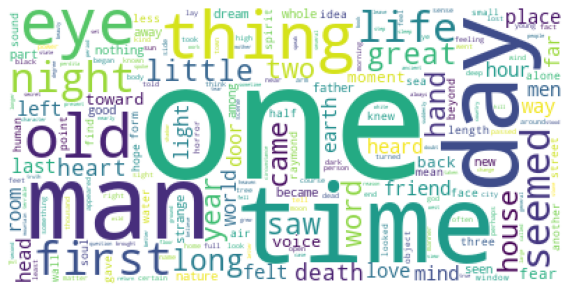

In [56]:
# join the different text together
longText = ','.join(list(authors_data_df['text_processed'].values))
# generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)
# visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

<AxesSubplot:xlabel='words', ylabel='count'>

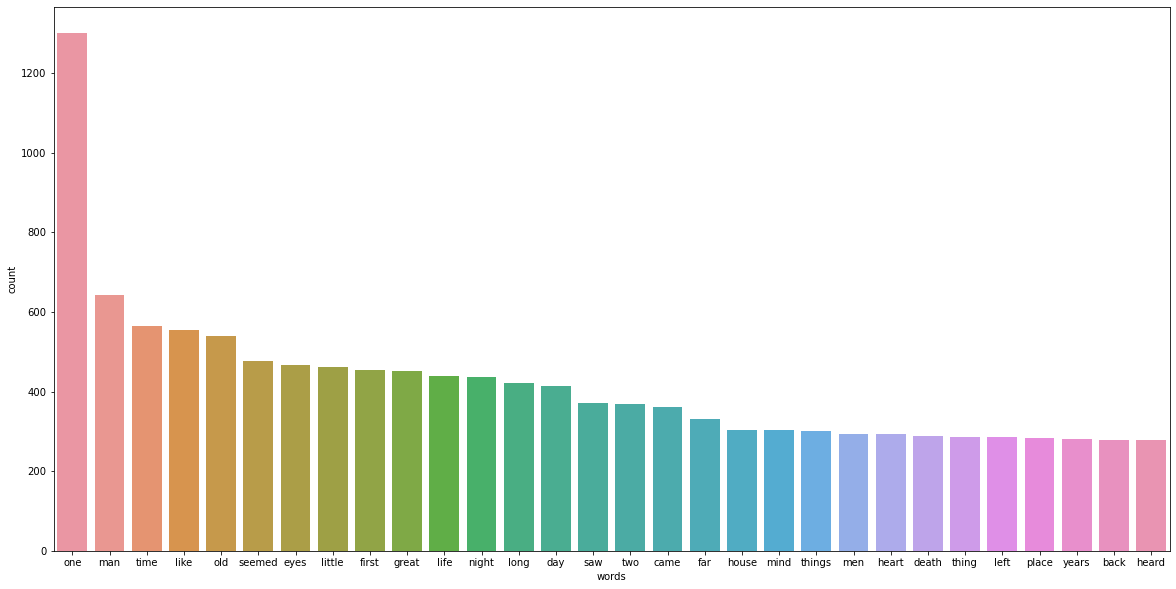

In [57]:
from collections import Counter
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = longText.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

#### The words like time, thing, one, came, year, upon, eye, day, man, night, old etc we can observe in this wordcloud

In [17]:
hplDatadf = authors_data_df[authors_data_df.author=="HPL"]
hplDatadf.head()

,text,author,text_length,text_processed
1,It never once occurred to me that the fumbling...,HPL,71,It occurred fumbling mere mistake
4,"Finding nothing else, not even gold, the Super...",HPL,174,Finding nothing else gold Superintendent aband...
12,Herbert West needed fresh bodies because his l...,HPL,87,Herbert West needed fresh bodies life work rea...
13,The farm like grounds extended back very deepl...,HPL,86,The farm like grounds extended back deeply hil...
19,"His facial aspect, too, was remarkable for its...",HPL,305,His facial aspect remarkable maturity; shared ...


In [18]:
mwsDatadf = authors_data_df[authors_data_df.author=="MWS"]
mwsDatadf.head()

,text,author,text_length,text_processed
3,How lovely is spring As we looked from Windsor...,MWS,206,How lovely spring As looked Windsor Terrace si...
5,"A youth passed in solitude, my best years spen...",MWS,468,A youth passed solitude best years spent gentl...
9,I confess that neither the structure of langua...,MWS,144,I confess neither structure languages code gov...
10,He shall find that I can feel my injuries; he ...,MWS,107,"He find I feel injuries; learn dread revenge"" ..."
15,"He had escaped me, and I must commence a destr...",MWS,261,He escaped I commence destructive endless jour...


In [19]:
eapDatadf = authors_data_df[authors_data_df.author=="EAP"]
eapDatadf.head()

,text,author,text_length,text_processed
0,"This process, however, afforded me no means of...",EAP,231,This process afforded means ascertaining dimen...
2,"In his left hand was a gold snuff box, from wh...",EAP,200,In left hand gold snuff box capered hill cutti...
6,"The astronomer, perhaps, at this point, took r...",EAP,128,The astronomer perhaps point took refuge sugge...
7,The surcingle hung in ribands from my body.,EAP,43,The surcingle hung ribands body
8,I knew that you could not say to yourself 'ste...,EAP,488,I knew 'stereotomy' brought think atomies theo...


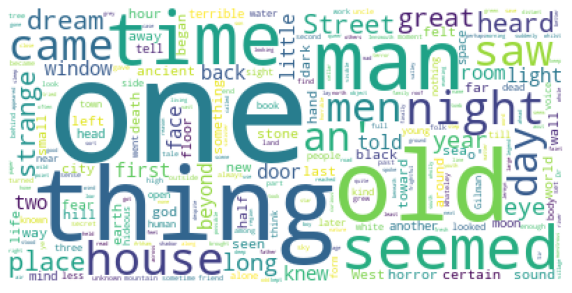

In [20]:
# join the different text together
longText = ','.join(list(hplDatadf['text_processed'].values))
# generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)

# visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

<AxesSubplot:xlabel='words', ylabel='count'>

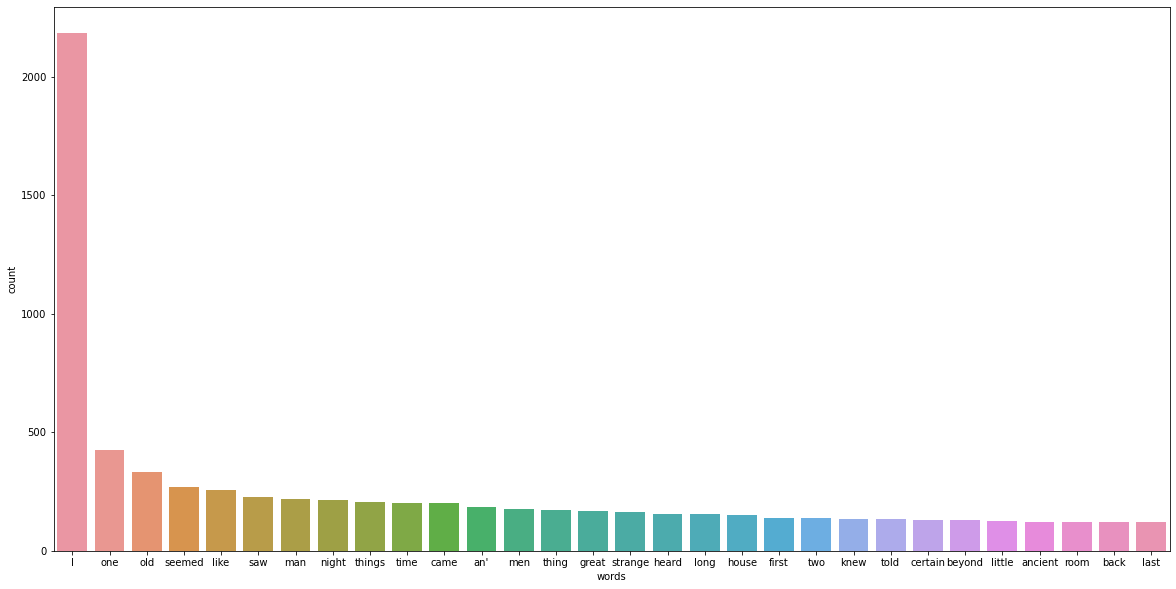

In [21]:
from collections import Counter
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = longText.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

### HP lovecraft wordcloud displays words like "night", "death","dream", "dead","fear","horror", "strange", "hideous", "ancient" which seem to resonate with themes that the author was famous for

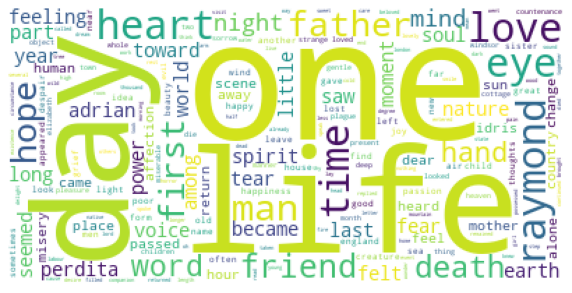

In [63]:
# join the different text together
longText = ','.join(list(mwsDatadf['text_processed'].values))
# generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)
# visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Mary Shelley wordcloud displays words as fear, heart, raymond, mind, soul, power, hope, feeling, death,spirit,friend, death. Positive as well as negative words

<AxesSubplot:xlabel='words', ylabel='count'>

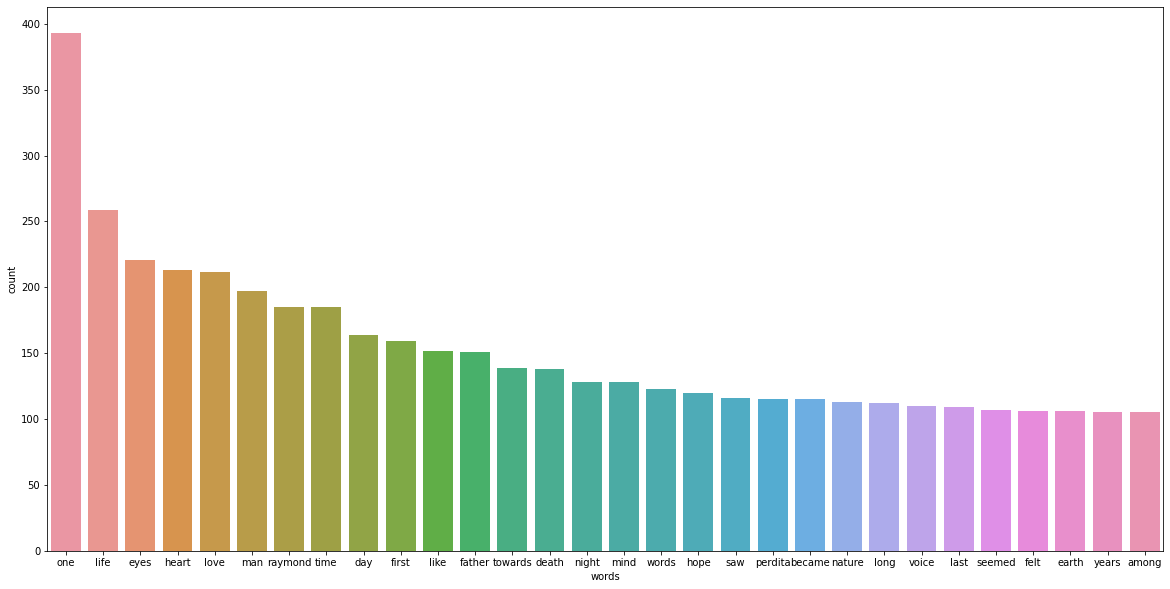

In [64]:
from collections import Counter
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = longText.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

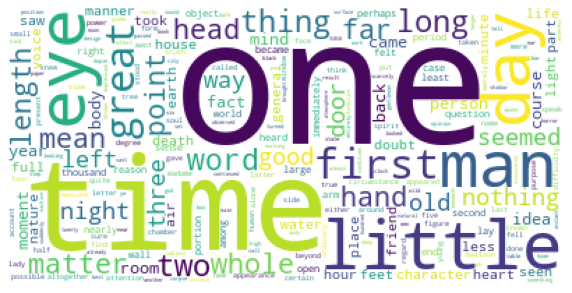

In [65]:
# join the different text together
longText = ','.join(list(eapDatadf['text_processed'].values))
# generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)
# visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

<AxesSubplot:xlabel='words', ylabel='count'>

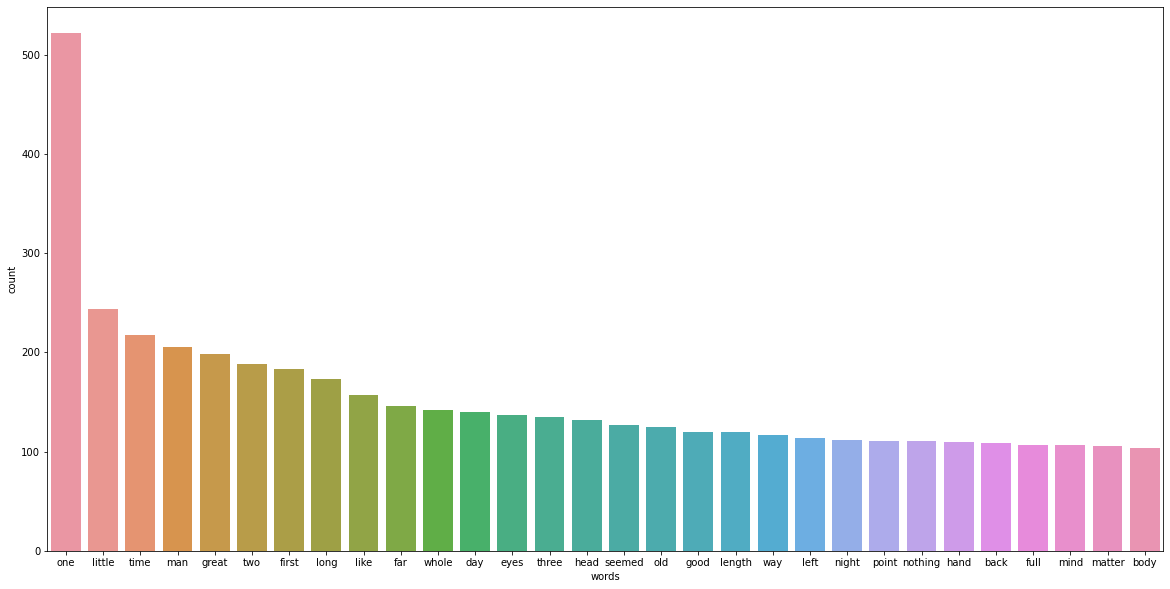

In [66]:
from collections import Counter
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = longText.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

#### Edgar Allan Poe wordcloud displays words as life,end,friend, night, far, open,eye, great, one, little, time, good, manner, moment etc

### Preparing data for Topic Modelling

#### Step 1 Processed text to words or tokens

In [25]:
def text_to_tokens (textSentences):
    for sent in textSentences:
        yield(simple_preprocess(str(sent),deacc=True))

In [26]:
wordsData=authors_data_df.text_processed.values.tolist()
wordsDataList = list(text_to_tokens(wordsData))
print(wordsDataList[:1])

[['this', 'process', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'circuit', 'return', 'point', 'whence', 'set', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall']]


#### Step 2 Building N grams

In [27]:
# Building the tokens
tokens = Phrases(wordsDataList,min_count=5,threshold=100)
tokensModel = phrases.Phraser(tokens)

In [28]:
def make_tokens_model(textSentences):
   return[tokensModel[doc] for doc in textSentences]

In [29]:
def lemmatizedText(textSentences, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    textSent_Output = []
    for sent in textSentences:
        doc = nlp(" ".join(sent))
        textSent_Output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return textSent_Output

#### Step 3 Lemmatize  Is the process of converting the words to the root words

In [30]:
# form n grams
dataWordsngrams = make_tokens_model(wordsDataList)
dataWordsngrams[:2]

[['this',
  'process',
  'afforded',
  'means',
  'ascertaining',
  'dimensions',
  'dungeon',
  'circuit',
  'return',
  'point',
  'whence',
  'set',
  'aware',
  'fact',
  'perfectly',
  'uniform',
  'seemed',
  'wall'],
 ['it', 'occurred', 'fumbling', 'mere', 'mistake']]

In [31]:
# initialize spacy "en" model keeping only the tagger component 
nlp = spacy.load("en_core_web_sm",disable=['parser','ner'])
# lemmatize keeping only noun, adj, adv and verbs
lemmatizedTextData = lemmatizedText(dataWordsngrams, allowed_postags=["NOUN","ADJ","VERB","ADV"])
print(lemmatizedTextData[:1])

[['process', 'afford', 'mean', 'ascertain', 'dimension', 'return', 'point', 'whence', 'set', 'aware', 'fact', 'perfectly', 'uniform', 'seem', 'wall']]


#### Step 4 Building the corpora

In [34]:
# create dictionary
dictObject = corpora.Dictionary(lemmatizedTextData)
# create corpus
textData = lemmatizedTextData
dictObject[0]

'afford'

In [35]:
# term document frequency
corpusData = [dictObject.doc2bow(text) for text in textData]
print(corpusData[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [36]:
# Human readable format of the term frequency corpus 
[[(dictObject[idx], count) for idx, count in x] for x in corpusData[:1]]

[[('afford', 1),
  ('ascertain', 1),
  ('aware', 1),
  ('dimension', 1),
  ('fact', 1),
  ('mean', 1),
  ('perfectly', 1),
  ('point', 1),
  ('process', 1),
  ('return', 1),
  ('seem', 1),
  ('set', 1),
  ('uniform', 1),
  ('wall', 1),
  ('whence', 1)]]

### Build the model

In [68]:
n_topics = 2
ldaModel = ldamodel.LdaModel(corpus=corpusData,
                            id2word = dictObject,
                            num_topics=n_topics,
                            random_state=123,
                            chunksize=100,
                            passes=10,
                            alpha=0.01,
                            eta='auto',
                            iterations=400,
                            per_word_topics = True                            
                            )

In [69]:
# print the keyword in the topics
pprint(ldaModel.print_topics())

[(0,
  '0.006*"time" + 0.004*"man" + 0.004*"life" + 0.004*"great" + 0.004*"day" + '
  '0.003*"good" + 0.003*"give" + 0.003*"little" + 0.003*"word" + 0.003*"long"'),
 (1,
  '0.007*"see" + 0.006*"man" + 0.005*"eye" + 0.005*"come" + 0.005*"old" + '
  '0.005*"look" + 0.004*"love" + 0.004*"night" + 0.004*"long" + 0.004*"seem"')]


#### the statistical analysis results displayed as above but how de we interprete these 3 topics and can we map them to the 3 authors?

#### Not all topics are semantically coherent or interpretable.How do we measure the interpretabilty and goodness of the model?Coherence score the statistical measures to check the goodness of the topic model

In [70]:
coherenceModelLda = CoherenceModel(model=ldaModel, texts = lemmatizedTextData,dictionary=dictObject,coherence='c_v')
coherenceScore = coherenceModelLda.get_coherence()
print(coherenceScore)

0.2047869186363725


In [71]:
coherenceModelLda = CoherenceModel(model=ldaModel, texts = lemmatizedTextData,dictionary=dictObject,coherence='u_mass')
coherenceScore = coherenceModelLda.get_coherence()
print(coherenceScore)

-3.5035632731894997


#### good model must have non overlapping topics, the distance shows how semantically different the topics are. the further they are apart, better the topics are

In [72]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(ldaModel,corpusData,dictObject)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.165971  0.0       1        1  50.996188
1     -0.165971  0.0       2        1  49.003812, topic_info=       Term        Freq       Total Category  logprob  loglift
212    love  420.000000  420.000000  Default  30.0000  30.0000
1290  voice  387.000000  387.000000  Default  29.0000  29.0000
42    heart  356.000000  356.000000  Default  28.0000  28.0000
80     good  341.000000  341.000000  Default  27.0000  27.0000
1199    die  299.000000  299.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
534    tell  281.781869  438.689046   Topic2  -5.8268   0.2706
75     feel  294.971502  539.862295   Topic2  -5.7810   0.1088
267   earth  227.687007  282.298396   Topic2  -6.0399   0.4983
146     day  239.752965  598.484106   Topic2  -5.9883  -0.2015
322   place  230.267294  441.911821   Topic2  -6.0287   0.0614

[156 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2118      1  0.998210     account
2118      2  0.007860     account
2250      1  0.984405  altogether
2250      2  0.012868  altogether
694       1  0.603017      appear
...     ...       ...         ...
756       2  0.267478        word
2265      1  0.997867       write
2265      2  0.004989       write
52        1  0.659250        year
52        2  0.340799        year

[233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [73]:
n_topics = 3
ldaModel = ldamodel.LdaModel(corpus=corpusData,
                            id2word = dictObject,
                            num_topics=n_topics,
                            random_state=123,
                            chunksize=100,
                            passes=10,
                            alpha=0.01,
                            eta='auto',
                            iterations=400,
                            per_word_topics = True                            
                            )

In [74]:
# print the keyword in the topics
pprint(ldaModel.print_topics())

[(0,
  '0.008*"come" + 0.006*"see" + 0.006*"time" + 0.005*"go" + 0.005*"night" + '
  '0.005*"hear" + 0.005*"day" + 0.005*"hand" + 0.005*"leave" + 0.005*"place"'),
 (1,
  '0.009*"see" + 0.008*"seem" + 0.008*"thing" + 0.008*"man" + 0.007*"old" + '
  '0.007*"dream" + 0.006*"look" + 0.006*"eye" + 0.006*"face" + 0.005*"form"'),
 (2,
  '0.007*"life" + 0.005*"love" + 0.005*"word" + 0.005*"heart" + 0.005*"feel" + '
  '0.004*"return" + 0.004*"time" + 0.004*"death" + 0.004*"idea" + 0.004*"man"')]


In [75]:
coherenceModelLda = CoherenceModel(model=ldaModel, texts = lemmatizedTextData,dictionary=dictObject,coherence='c_v')
coherenceScore = coherenceModelLda.get_coherence()
print(coherenceScore)

0.3055926403668976


In [76]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(ldaModel,corpusData,dictObject)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057504 -0.247101       1        1  39.873600
2     -0.199652  0.170209       2        1  36.492477
1      0.257155  0.076892       3        1  23.633923, topic_info=       Term        Freq       Total Category  logprob  loglift
619    come  616.000000  616.000000  Default  30.0000  30.0000
520     see  876.000000  876.000000  Default  29.0000  29.0000
10     seem  651.000000  651.000000  Default  28.0000  28.0000
1022  dream  302.000000  302.000000  Default  27.0000  27.0000
571   thing  630.000000  630.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
522    tree  152.909782  199.659434   Topic3  -5.7088   1.1757
1382  human  156.808493  295.224338   Topic3  -5.6837   0.8098
225     far  154.285637  340.895922   Topic3  -5.6999   0.6497
1199    die  149.793798  297.718260   Topic3  -5.7294   0.7556
1039   high  142.486343  240.681710   Topic3  -5.7794   0.9183

[191 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2118      2  0.992470    account
451       2  0.990955  affection
483       2  0.007887        age
483       3  0.993798        age
626       1  0.033801    ancient
...     ...       ...        ...
2995      2  0.009620        why
2995      3  0.990829        why
938       3  0.994212       wild
756       2  0.863627       word
756       3  0.135014       word

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [61]:
n_topics = 4
ldaModel = ldamodel.LdaModel(corpus=corpusData,
                            id2word = dictObject,
                            num_topics=n_topics,
                            random_state=123,
                            chunksize=100,
                            passes=10,
                            alpha=0.01,
                            eta='auto',
                            iterations=400,
                            per_word_topics = True                            
                            )

In [62]:
# print the keyword in the topics
pprint(ldaModel.print_topics())

[(0,
  '0.013*"day" + 0.009*"come" + 0.009*"go" + 0.009*"first" + 0.008*"death" + '
  '0.008*"begin" + 0.007*"tell" + 0.007*"heart" + 0.007*"old" + 0.007*"thing"'),
 (1,
  '0.007*"full" + 0.007*"enter" + 0.007*"part" + 0.007*"length" + 0.007*"less" '
  '+ 0.007*"object" + 0.006*"name" + 0.006*"lose" + 0.006*"long" + '
  '0.006*"seek"'),
 (2,
  '0.012*"life" + 0.009*"love" + 0.007*"end" + 0.006*"return" + 0.006*"thing" '
  '+ 0.006*"die" + 0.006*"last" + 0.006*"human" + 0.006*"idea" + 0.006*"feel"'),
 (3,
  '0.014*"see" + 0.010*"man" + 0.008*"seem" + 0.008*"long" + 0.007*"time" + '
  '0.006*"look" + 0.006*"voice" + 0.006*"eye" + 0.006*"appear" + 0.006*"call"')]


In [63]:
coherenceModelLda = CoherenceModel(model=ldaModel, texts = lemmatizedTextData,dictionary=dictObject,coherence='c_v')
coherenceScore = coherenceModelLda.get_coherence()
print(coherenceScore)

0.2294835195748281


In [67]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(ldaModel,corpusData,dictObject)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.089226  0.235872       1        1  31.920345
0     -0.055217 -0.269724       2        1  24.680387
2     -0.273563  0.085845       3        1  24.499717
1      0.239554 -0.051993       4        1  18.899552, topic_info=       Term        Freq       Total Category  logprob  loglift
520     see  903.000000  903.000000  Default  30.0000  30.0000
146     day  614.000000  614.000000  Default  29.0000  29.0000
156    life  585.000000  585.000000  Default  28.0000  28.0000
226      go  437.000000  437.000000  Default  27.0000  27.0000
461   first  427.000000  427.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
24    great  202.350840  556.278388   Topic4  -5.2051   0.6548
124    long  212.245864  703.867064   Topic4  -5.1574   0.4672
296     man  196.682987  983.942317   Topic4  -5.2336   0.0561
52     year  145.251832  365.355357   Topic4  -5.5367   0.7436
1018  night  146.264171  502.754215   Topic4  -5.5297   0.4313

[196 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2118      4  0.995291  account
483       4  0.993270      age
1425      3  0.995679    alone
1439      2  0.994929   always
694       1  0.997960   appear
...     ...       ...      ...
460       1  0.998159    world
2265      3  0.994084    write
52        2  0.602153     year
52        4  0.396874     year
392       4  0.998104    young

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [ ]:
## pyLDAvis topic IDs doesn't correspond to gensim topic IDs ...

In [ ]:
## Topic1 <===> EAP
## Topic2 <===> MWS
## Topic3 <===> HPL